**IMPORTING LIBRARIES**

In [78]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import random
import shutil
import seaborn as sns
from PIL import Image

#tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#show images using OpenCV
from google.colab.patches import cv2_imshow

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [79]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**DATA EXPLORATION**

In [80]:
#set path to the folder containimg all the image folders
folder_path = "/content/drive/MyDrive/chest_xray"

In [81]:
len(os.listdir("/content/drive/MyDrive/chest_xray"))

3

**The dataset consists of 3 folders**

In [82]:
folders=[]
folders= [f for f in sorted (os.listdir('/content/drive/MyDrive/chest_xray'))]
print(folders)

['test', 'train', 'val']


In [83]:
#define data directories
train_data_dir = "/content/drive/MyDrive/chest_xray/train"
test_data_dir = "/content/drive/MyDrive/chest_xray/test"
val_data_dir = "/content/drive/MyDrive/chest_xray/val"

In [84]:
folders=[]
folders= [f for f in sorted (os.listdir('/content/drive/MyDrive/chest_xray/train'))]
print(folders)

['NORMAL', 'PNEUMONIA']


In [85]:
folders=[]
folders= [f for f in sorted (os.listdir('/content/drive/MyDrive/chest_xray/test'))]
print(folders)

['NORMAL', 'PNEUMONIA']


In [86]:
folders=[]
folders= [f for f in sorted (os.listdir('/content/drive/MyDrive/chest_xray/val'))]
print(folders)

['NORMAL', 'PNEUMONIA']


**Each folder has 2 subfolders namely NORMAL and PNEUMONIA**

In [87]:
len(os.listdir("/content/drive/MyDrive/chest_xray/train/PNEUMONIA"))

3875

In [88]:
len(os.listdir("/content/drive/MyDrive/chest_xray/train/NORMAL"))

1350

In [89]:
len(os.listdir("/content/drive/MyDrive/chest_xray/test/PNEUMONIA"))

390

In [90]:
len(os.listdir("/content/drive/MyDrive/chest_xray/test/NORMAL"))

234

In [91]:
len(os.listdir("/content/drive/MyDrive/chest_xray/val/PNEUMONIA"))

8

In [92]:
len(os.listdir("/content/drive/MyDrive/chest_xray/val/NORMAL"))

7

**The train, test and val subfolders have 3875, 390, 8 and 1350, 234, 8 pneumonic and normal chest xrays respectively**

**DATA VISUALISATION**

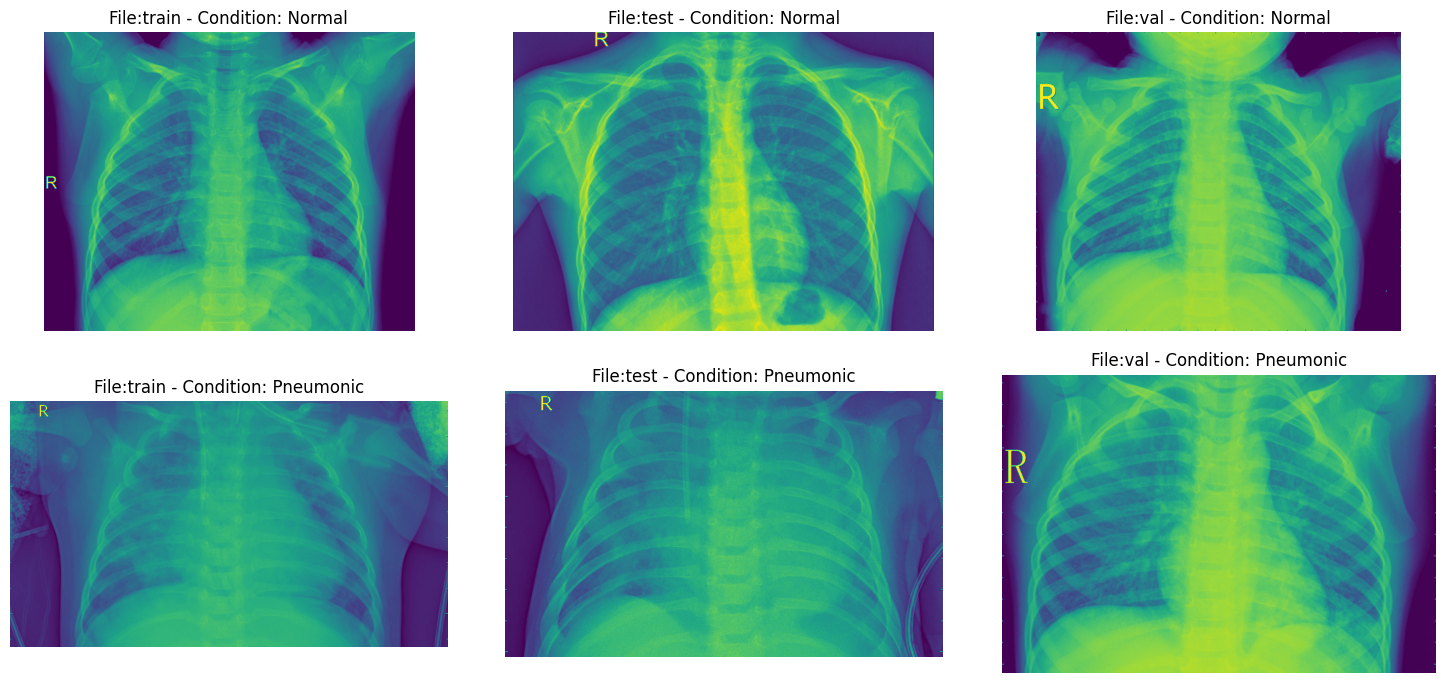

In [93]:
#create subplots
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()

#loop through the folders
for i, _set in enumerate(['train', 'test', 'val']):
    set_path = os.path.join(folder_path, _set)

    #show normal image
    ax[i].axis('off')
    normal_images = os.listdir(os.path.join(set_path, 'NORMAL'))
    normal_image_path = os.path.join(set_path, 'NORMAL', normal_images[0])
    normal_image = plt.imread(normal_image_path)
    ax[i].imshow(normal_image)
    ax[i].set_title('File:{} - Condition: Normal'.format(_set))

    #show abnormal image
    ax[i+3].axis('off')
    abnormal_images = os.listdir(os.path.join(set_path, 'PNEUMONIA'))
    abnormal_image_path = os.path.join(set_path, 'PNEUMONIA', abnormal_images[0])
    abnormal_image = plt.imread(abnormal_image_path)
    ax[i+3].imshow(abnormal_image)
    ax[i+3].set_title('File:{} - Condition: Pneumonic'.format(_set))

#show the images
plt.show()

**Healthy and pneumonic chests in each folder are displayed**

**DATA AUGMENTATION**

In [94]:
#Resiz#set the desired image size after resizing and batch  size
image_size = (224, 224)
batch_size = 32

In [95]:
#create data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 /255, #rescale pixel value to [0,1]
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [96]:
#import images from dataset for train
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(224, 224), #adjust to VGG input size
    batch_size=batch_size,
    class_mode='binary'
)

Found 5225 images belonging to 2 classes.


In [97]:
test_datagen =ImageDataGenerator(rescale=1.0/255)

In [98]:
#import images from dataset for test
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    shuffle=False,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
)

Found 624 images belonging to 2 classes.


In [99]:
#import images from dataset for val
validation_generator = test_datagen.flow_from_directory(
    val_data_dir,
    shuffle=False,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
)

Found 15 images belonging to 2 classes.


In [100]:
#fix seed for random gen
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

**BUIDING CNN MODEL**

In [ ]:
#Build model
model = Sequential()

#add first convolution layer with 128 filters and 3 by 3 kernels
model.add(Conv2D(128, (3,3), padding = "same", input_shape = (224, 224, 3), activation = "relu"  ))

#add maxpooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#add second convolution layer with 64 filters and 3 by 3 kernel
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))

#add max pooling to reduce size of output
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#flatten
model.add(Flatten())

#add fully connected layer
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))

#add output layer
model.add(Dense(1,activation = 'sigmoid'))

#using adam optimizer
opt = Adam()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 128)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 128)    512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                        

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
history= model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator,)
)

Epoch 1/10
164/164 [==============================] - 1305s 8s/step - loss: 1.6550 - accuracy: 0.7562 - val_loss: 30.8403 - val_accuracy: 0.6250
Epoch 2/10
164/164 [==============================] - 152s 916ms/step - loss: 0.3596 - accuracy: 0.8589 - val_loss: 9.1196 - val_accuracy: 0.6250
Epoch 3/10
164/164 [==============================] - 129s 787ms/step - loss: 0.2643 - accuracy: 0.8779 - val_loss: 1.5510 - val_accuracy: 0.6314
Epoch 4/10
164/164 [==============================] - 127s 774ms/step - loss: 0.2678 - accuracy: 0.8754 - val_loss: 0.4438 - val_accuracy: 0.8013
Epoch 5/10
164/164 [==============================] - 127s 777ms/step - loss: 0.2868 - accuracy: 0.8856 - val_loss: 23.5992 - val_accuracy: 0.4054
Epoch 6/10
164/164 [==============================] - 127s 774ms/step - loss: 0.2267 - accuracy: 0.8884 - val_loss: 0.5160 - val_accuracy: 0.8141
Epoch 7/10
164/164 [==============================] - 126s 767ms/step - loss: 0.2314 - accuracy: 0.8900 - val_loss: 6.4338 -

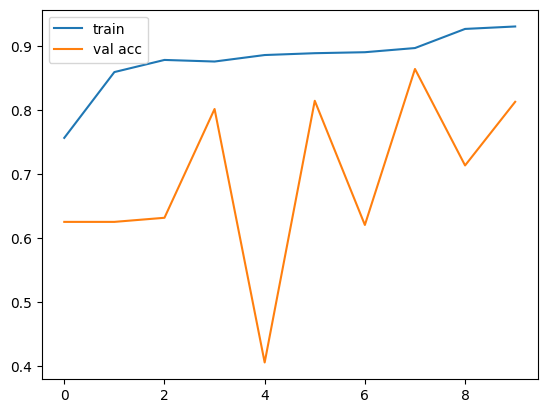

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label ='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy Val')

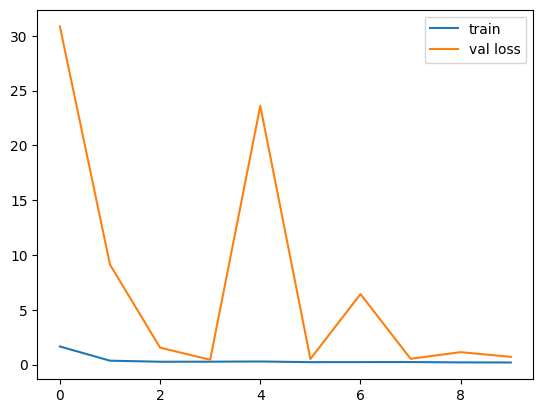

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
plt.savefig('Loss Val')

**Model Evaluation**

In [ ]:
evaluation=model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100: .2f}%")

evaluation=model.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100: .2f}%")

20/20 [==============================] - 6s 287ms/step - loss: 0.7096 - accuracy: 0.8125
Test Accuracy:  81.25%
164/164 [==============================] - 123s 749ms/step - loss: 0.2513 - accuracy: 0.8999
Train Accuracy:  89.99%


In [ ]:
predicted_val=model.predict(test_generator, steps=len(test_generator))

20/20 [==============================] - 6s 269ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_generator.classes, predicted_val > 0.5))
pd.DataFrame(classification_report(test_generator.classes, predicted_val > 0.5, output_dict=True))

[[129 105]
 [ 12 378]]


,0,1,accuracy,macro avg,weighted avg
precision,0.914894,0.782609,0.8125,0.848751,0.832216
recall,0.551282,0.969231,0.8125,0.760256,0.812500
f1-score,0.688000,0.865979,0.8125,0.776990,0.799237
support,234.000000,390.000000,0.8125,624.000000,624.000000


**USING PRE TRAINED MODELS**

**VGG16**


In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [ ]:
#fix seed for random gen
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
#define VGG model
from keras.applications import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#to avoid training existing weight, this freezes all conv VGG16layers
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)
predictions = Dense(1, activation = 'sigmoid')(x)

In [ ]:
#create model object
from keras.applications.vgg16 import preprocess_input

model2 =Model(inputs = vgg16.input, outputs= predictions)

In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#optimisation method
model2.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [ ]:
history2 =model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator,)
)

Epoch 1/10
164/164 [==============================] - 148s 872ms/step - loss: 0.2297 - accuracy: 0.9089 - val_loss: 0.2509 - val_accuracy: 0.9054
Epoch 2/10
164/164 [==============================] - 156s 953ms/step - loss: 0.1325 - accuracy: 0.9500 - val_loss: 0.2047 - val_accuracy: 0.9295
Epoch 3/10
164/164 [==============================] - 158s 966ms/step - loss: 0.1267 - accuracy: 0.9518 - val_loss: 0.2611 - val_accuracy: 0.9022
Epoch 4/10
164/164 [==============================] - 157s 956ms/step - loss: 0.1083 - accuracy: 0.9617 - val_loss: 0.3312 - val_accuracy: 0.8958
Epoch 5/10
164/164 [==============================] - 139s 843ms/step - loss: 0.1158 - accuracy: 0.9573 - val_loss: 0.2425 - val_accuracy: 0.9199
Epoch 6/10
164/164 [==============================] - 141s 854ms/step - loss: 0.0875 - accuracy: 0.9659 - val_loss: 0.3064 - val_accuracy: 0.8942
Epoch 7/10
164/164 [==============================] - 142s 860ms/step - loss: 0.0869 - accuracy: 0.9657 - val_loss: 0.3564 -

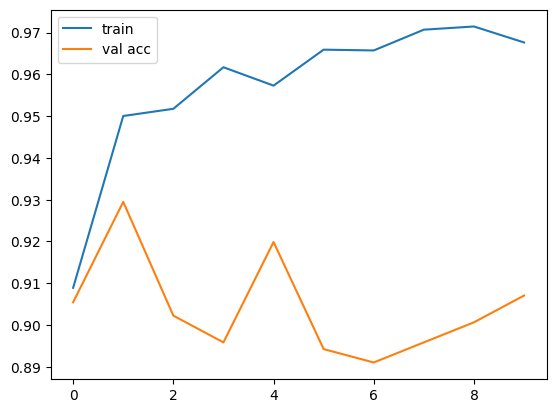

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history2.history['accuracy'], label = 'train')
plt.plot(history2.history['val_accuracy'], label ='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy Val')

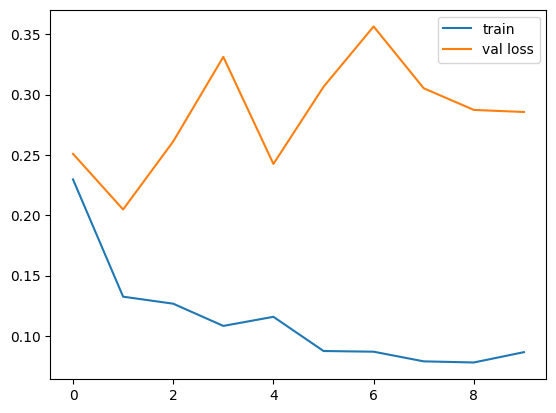

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history2.history['loss'], label = 'train')
plt.plot(history2.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
plt.savefig('Loss Val')

In [ ]:
evaluation=model2.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100: .2f}%")

evaluation=model2.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100: .2f}%")

20/20 [==============================] - 7s 309ms/step - loss: 0.2855 - accuracy: 0.9071
Test Accuracy:  90.71%
164/164 [==============================] - 120s 729ms/step - loss: 0.0609 - accuracy: 0.9776
Train Accuracy:  97.76%


In [ ]:
predicted_val=model2.predict(test_generator, steps=len(test_generator))

20/20 [==============================] - 6s 296ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_generator.classes, predicted_val > 0.5))
pd.DataFrame(classification_report(test_generator.classes, predicted_val > 0.5, output_dict=True))

[[189  45]
 [ 13 377]]


,0,1,accuracy,macro avg,weighted avg
precision,0.935644,0.893365,0.907051,0.914504,0.909219
recall,0.807692,0.966667,0.907051,0.887179,0.907051
f1-score,0.866972,0.928571,0.907051,0.897772,0.905472
support,234.000000,390.000000,0.907051,624.000000,624.000000


**DenseNet121** **bold text**

In [101]:
#clear backend
from tensorflow.keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [102]:
#fix seed for random gen
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [103]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D

In [104]:
DenseNetmodel=DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classifier_activation=None
)

In [125]:
x = Flatten()(DenseNetmodel.output)
predictions = Dense(1, activation = 'sigmoid')(x)

In [106]:
model3 =Model(inputs = DenseNetmodel.input, outputs= predictions)

In [107]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                                )                                                           

In [108]:
x=model3.output
#x=GlobalAveragePooling2D()(x)
predictions=Dense(1, activation='sigmoid')(x)

In [109]:
model3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [110]:
history3 =model3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator,)
)

Epoch 1/10
164/164 [==============================] - 213s 880ms/step - loss: 0.1964 - accuracy: 0.9271 - val_loss: 0.4822 - val_accuracy: 0.8381
Epoch 2/10
164/164 [==============================] - 144s 873ms/step - loss: 0.1243 - accuracy: 0.9525 - val_loss: 1.6419 - val_accuracy: 0.6731
Epoch 3/10
164/164 [==============================] - 142s 865ms/step - loss: 0.1062 - accuracy: 0.9602 - val_loss: 0.5005 - val_accuracy: 0.8093
Epoch 4/10
164/164 [==============================] - 140s 850ms/step - loss: 0.0981 - accuracy: 0.9610 - val_loss: 0.6113 - val_accuracy: 0.7869
Epoch 5/10
164/164 [==============================] - 137s 834ms/step - loss: 0.0890 - accuracy: 0.9667 - val_loss: 0.7644 - val_accuracy: 0.7564
Epoch 6/10
164/164 [==============================] - 137s 835ms/step - loss: 0.0871 - accuracy: 0.9682 - val_loss: 0.3614 - val_accuracy: 0.8750
Epoch 7/10
164/164 [==============================] - 137s 835ms/step - loss: 0.0935 - accuracy: 0.9648 - val_loss: 0.2027 -

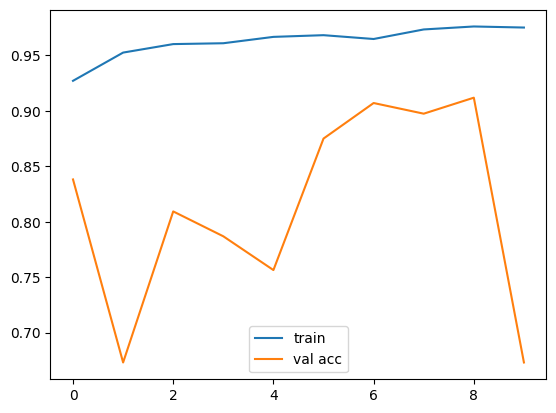

<Figure size 640x480 with 0 Axes>

In [111]:
plt.plot(history3.history['accuracy'], label = 'train')
plt.plot(history3.history['val_accuracy'], label ='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy Val')

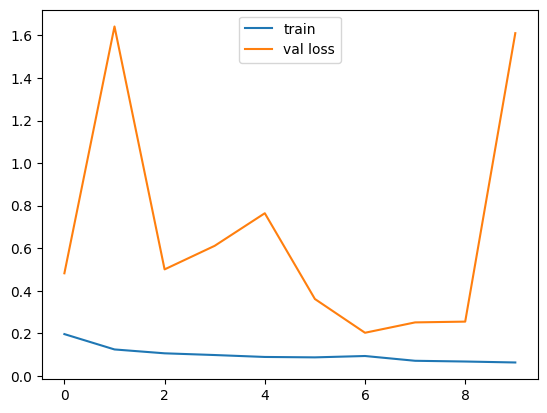

<Figure size 640x480 with 0 Axes>

In [112]:
plt.plot(history3.history['loss'], label = 'train')
plt.plot(history3.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
plt.savefig('Loss Val')

In [113]:
evaluation=model3.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100: .2f}%")

evaluation=model3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100: .2f}%")

20/20 [==============================] - 7s 309ms/step - loss: 1.6106 - accuracy: 0.6731
Test Accuracy:  67.31%
164/164 [==============================] - 117s 711ms/step - loss: 1.6984 - accuracy: 0.6867
Train Accuracy:  68.67%


In [115]:
predicted_val=model3.predict(test_generator, steps=len(test_generator))

20/20 [==============================] - 9s 279ms/step


In [116]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_generator.classes, predicted_val > 0.5))
pd.DataFrame(classification_report(test_generator.classes, predicted_val > 0.5, output_dict=True))

[[231   3]
 [201 189]]


,0,1,accuracy,macro avg,weighted avg
precision,0.534722,0.984375,0.673077,0.759549,0.815755
recall,0.987179,0.484615,0.673077,0.735897,0.673077
f1-score,0.693694,0.649485,0.673077,0.671589,0.666063
support,234.000000,390.000000,0.673077,624.000000,624.000000


**ResNet**

In [117]:
#clear backend
from tensorflow.keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [118]:
#fix seed for random gen
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [119]:
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D


In [121]:
ResNetmodel=ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    classifier_activation=None
)

94765736/94765736 [==============================] - 1s 0us/step


In [124]:
#to avoid training existing weight, this freezes all conv layers
for layer in ResNetmodel.layers:
    layer.trainable = False

In [126]:
x = Flatten()(ResNetmodel.output)
predictions = Dense(1, activation = 'sigmoid')(x)

In [127]:
model4 =Model(inputs = ResNetmodel.input, outputs= predictions)

In [128]:
model4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [129]:
model4.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [130]:
history4= model4.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator,)
)

Epoch 1/10
164/164 [==============================] - 136s 803ms/step - loss: 0.6219 - accuracy: 0.7596 - val_loss: 0.4107 - val_accuracy: 0.8205
Epoch 2/10
164/164 [==============================] - 124s 752ms/step - loss: 0.3319 - accuracy: 0.8463 - val_loss: 0.4413 - val_accuracy: 0.7821
Epoch 3/10
164/164 [==============================] - 124s 753ms/step - loss: 0.3375 - accuracy: 0.8490 - val_loss: 0.3910 - val_accuracy: 0.8317
Epoch 4/10
164/164 [==============================] - 124s 759ms/step - loss: 0.3206 - accuracy: 0.8599 - val_loss: 0.3231 - val_accuracy: 0.8606
Epoch 5/10
164/164 [==============================] - 125s 762ms/step - loss: 0.3124 - accuracy: 0.8630 - val_loss: 0.3808 - val_accuracy: 0.8381
Epoch 6/10
164/164 [==============================] - 125s 757ms/step - loss: 0.2587 - accuracy: 0.8869 - val_loss: 0.4427 - val_accuracy: 0.8077
Epoch 7/10
164/164 [==============================] - 128s 784ms/step - loss: 0.2978 - accuracy: 0.8785 - val_loss: 0.4087 -

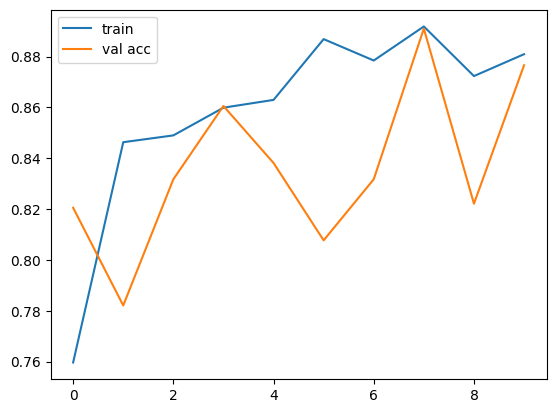

<Figure size 640x480 with 0 Axes>

In [132]:
plt.plot(history4.history['accuracy'], label = 'train')
plt.plot(history4.history['val_accuracy'], label ='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy Val')

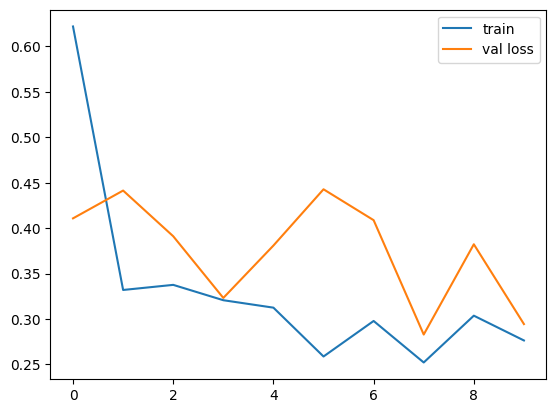

<Figure size 640x480 with 0 Axes>

In [133]:
plt.plot(history4.history['loss'], label = 'train')
plt.plot(history4.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
plt.savefig('Loss Val')

**Model Evaluation**

In [134]:
evaluation=model4.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100: .2f}%")

evaluation=model3.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100: .2f}%")

20/20 [==============================] - 6s 280ms/step - loss: 0.2944 - accuracy: 0.8766
Test Accuracy:  87.66%
164/164 [==============================] - 119s 722ms/step - loss: 1.7126 - accuracy: 0.6813
Train Accuracy:  68.13%


In [135]:
predicted_val=model4.predict(test_generator, steps=len(test_generator))

20/20 [==============================] - 9s 305ms/step


In [136]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_generator.classes, predicted_val > 0.5))
pd.DataFrame(classification_report(test_generator.classes, predicted_val > 0.5, output_dict=True))

[[170  64]
 [ 13 377]]


,0,1,accuracy,macro avg,weighted avg
precision,0.928962,0.854875,0.876603,0.891919,0.882658
recall,0.726496,0.966667,0.876603,0.846581,0.876603
f1-score,0.815348,0.907341,0.876603,0.861344,0.872843
support,234.000000,390.000000,0.876603,624.000000,624.000000


**Inception V3**

In [137]:
#clear backend
from tensorflow.keras import backend
backend.clear_session

<function keras.backend.clear_session()>

In [138]:
#fix seed for random gen
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [139]:
from keras.applications import InceptionV3
from keras.layers import Dense, GlobalAveragePooling2D


In [140]:
Inceptionmodel=InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    classifier_activation=None
)

87910968/87910968 [==============================] - 0s 0us/step


In [141]:
#to avoid training existing weight, this freezes all conv layers
for layer in Inceptionmodel.layers:
    layer.trainable = False

In [142]:
x=Inceptionmodel.output
x=GlobalAveragePooling2D()(x)
predictions=Dense(1, activation='sigmoid')(x)

In [146]:
model5=Model(inputs=Inceptionmodel.input, outputs=predictions)

In [147]:
model5.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [148]:
history5= model5.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator,)
)

Epoch 1/10
164/164 [==============================] - 150s 880ms/step - loss: 0.2516 - accuracy: 0.8945 - val_loss: 0.4869 - val_accuracy: 0.7772
Epoch 2/10
164/164 [==============================] - 128s 779ms/step - loss: 0.2023 - accuracy: 0.9206 - val_loss: 0.3992 - val_accuracy: 0.8221
Epoch 3/10
164/164 [==============================] - 128s 779ms/step - loss: 0.1786 - accuracy: 0.9294 - val_loss: 0.4799 - val_accuracy: 0.7997
Epoch 4/10
164/164 [==============================] - 126s 768ms/step - loss: 0.1754 - accuracy: 0.9317 - val_loss: 0.3413 - val_accuracy: 0.8558
Epoch 5/10
164/164 [==============================] - 120s 735ms/step - loss: 0.1682 - accuracy: 0.9353 - val_loss: 0.3659 - val_accuracy: 0.8462
Epoch 6/10
164/164 [==============================] - 119s 723ms/step - loss: 0.1655 - accuracy: 0.9313 - val_loss: 0.4316 - val_accuracy: 0.8269
Epoch 7/10
164/164 [==============================] - 120s 734ms/step - loss: 0.1672 - accuracy: 0.9372 - val_loss: 0.3215 -

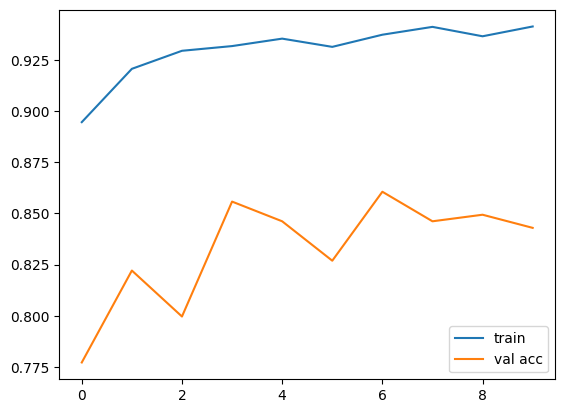

<Figure size 640x480 with 0 Axes>

In [149]:
plt.plot(history5.history['accuracy'], label = 'train')
plt.plot(history5.history['val_accuracy'], label ='val acc')
plt.legend()
plt.show()
plt.savefig('Accuracy Val')

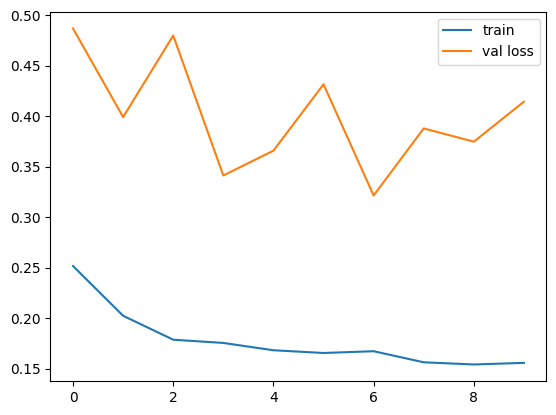

<Figure size 640x480 with 0 Axes>

In [150]:
plt.plot(history5.history['loss'], label = 'train')
plt.plot(history5.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
plt.savefig('Loss Val')

**Model Evaluation**

In [151]:
evaluation=model5.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100: .2f}%")

evaluation=model5.evaluate(train_generator)
print(f"Train Accuracy: {evaluation[1] * 100: .2f}%")

20/20 [==============================] - 6s 281ms/step - loss: 0.4144 - accuracy: 0.8429
Test Accuracy:  84.29%
164/164 [==============================] - 118s 720ms/step - loss: 0.1416 - accuracy: 0.9460
Train Accuracy:  94.60%


In [152]:
predicted_val=model5.predict(test_generator, steps=len(test_generator))

20/20 [==============================] - 8s 274ms/step


In [153]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(test_generator.classes, predicted_val > 0.5))
pd.DataFrame(classification_report(test_generator.classes, predicted_val > 0.5, output_dict=True))

[[149  85]
 [ 13 377]]


,0,1,accuracy,macro avg,weighted avg
precision,0.919753,0.816017,0.842949,0.867885,0.854918
recall,0.636752,0.966667,0.842949,0.801709,0.842949
f1-score,0.752525,0.884977,0.842949,0.818751,0.835307
support,234.000000,390.000000,0.842949,624.000000,624.000000
